In [1]:
import numpy as np

### The Two Armed Bandit Problem

Imagine a two armed bandit each returning on average values:

In [2]:
Rtrue = np.array([10,12])

We would like to learn to choose the arm with the highest reward with highest probability
### Policy iteration using function appoximation
Lets assume that the policy can be represented by the following function
\begin{equation*}
\pi (a) = \frac{\exp \big( \sum_{i=1}^2 \theta_i x_i(s,a) \big)}{\sum_{a = 1}^2\exp \big( \sum_{i=1}^2 \theta_ix_i(s,a) \big)}
\end{equation*}
and let the features be
\begin{equation*}
x_1(s,a) = \begin{cases} 1 & \mbox{when } a = 1 \\
                       0 & \mbox{otherwise}
         \end{cases}
\end{equation*}
and
\begin{equation*}
x_2(s,a) = \begin{cases} 1 & \mbox{when } a = 2 \\
                       0 & \mbox{otherwise}
         \end{cases}
\end{equation*} 
Then 
\begin{equation*}
\pi (1) = \frac{\exp \big( \theta_1 \big)}{\exp(\theta_1)+\exp(\theta_2)}
\end{equation*}
and
\begin{equation*}
\pi (2) = 1-\pi(1) = \frac{\exp \big( \theta_2 \big)}{\exp(\theta_1)+\exp(\theta_2)}
\end{equation*}

Note that there is only one state $s$ and so we can drop it, i.e. $\pi(s,a)\equiv \pi(a)$. Futhermore, using these linear features makes this representation equivalent to a lookup table where $\theta_i$ denote the value of action $i$. Lets see how we might use the REINFORCE algorithm we start by computing gradients for the logarithm of the policy function:


In [3]:
import sympy as sp
th1, th2, x1, x2 = sp.symbols('Theta1 Theta2 X1 X1')
sp.init_printing()

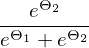

In [4]:
pi1 = sp.exp(th1) / ( sp.exp(th1) + sp.exp(th2) )
dpi1th1 = sp.simplify(sp.diff(sp.ln(pi1),th1))
dpi1th1

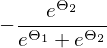

In [5]:
dpi1th2 = sp.simplify(sp.diff(sp.ln(pi1),th2))
dpi1th2

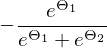

In [6]:
pi2 = sp.exp(th2) / ( sp.exp(th1) + sp.exp(th2) )
dpi2th1 = sp.simplify(sp.diff(sp.ln(pi2),th1))
dpi2th1

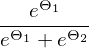

In [7]:
dpi2th2 = sp.simplify(sp.diff(sp.ln(pi2),th2))
dpi2th2

In other words the derivatives are:
\begin{equation*}
\frac{\partial \ln \pi(1|\theta)}{\partial \theta_1} = 1 - \pi(1)
\end{equation*}
\begin{equation*}
\frac{\partial \ln \pi(1|\theta)}{\partial \theta_2} = -\pi(2)
\end{equation*}
and
\begin{equation*}
\frac{\partial \ln \pi(2|\theta)}{\partial \theta_1}  = -\pi(1)
\end{equation*}
\begin{equation*}
\frac{\partial \ln \pi(2|\theta)}{\partial \theta_2} = 1-\pi(2)
\end{equation*}

In terms of our feature vector $x(s,a)\equiv x(a)$ we can write the above equations in a general matrix form:
\begin{equation*}
\nabla \ln \pi (a|\theta) = \vec{x}(a) - [\pi(1),\pi(2)] [\vec{x}(1),\vec{x}(2)]
\end{equation*}
where $[\vec{x}(1),\vec{x}(2)]$ form a 2x2 matrix (identity matrix in this case) and $[\pi(1),\pi(2)]$ is a row vector (1x2). The  $\vec{x}(a)$ is a (2x1) column vector, when $a=1$ it is $[1,0]^T$ and when $a=2$ it is $[0,1]^T$. See also equation (13.9) in the book. Now we have everything to implement REINFORCE:

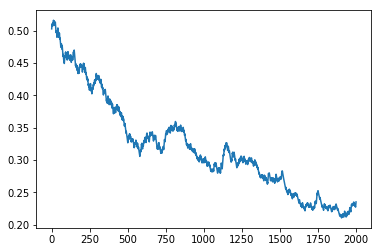

In [13]:
theta = np.ones(2) # equal value
alpha = .001 # step size
gamma = 1 # so ignore?
x = np.eye(2)
pi = lambda a, x, theta : np.exp(np.matmul(theta,x[:,a-1].T))/np.sum(np.exp(np.matmul(theta,x.T)))
life_of_pi = np.zeros( 2000 )
life_of_theta = np.zeros( (len(life_of_pi),2) )
for episode in range( len(life_of_pi) ):
    if np.random.uniform() < pi(1,x,theta):
        a = 1
    else:
        a = 2
    G = np.random.normal(loc=Rtrue[a-1]) # return of the bandit
    piGrad = x[:,a-1] - np.matmul(np.array( [pi(1,x,theta), pi(2,x,theta)] ), x)
    theta = theta + alpha * G * piGrad
    life_of_pi[episode] = pi(1,x,theta)
    life_of_theta[episode,:] = theta

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(life_of_pi)

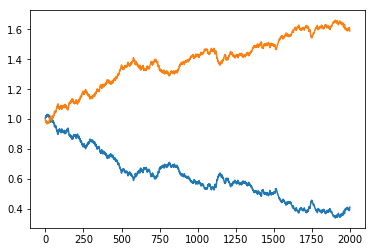

In [14]:
plt.plot(life_of_theta)

### REINFORCE with baseline:

array([ 9.97333981, 11.97385858])

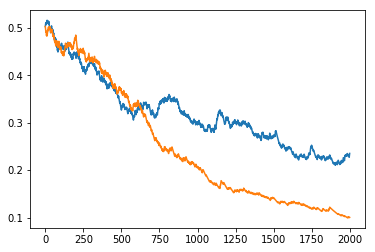

In [28]:
theta = np.ones(2) # equal value
alpha = .001 # step size
gamma = 1 # so ignore?
x = np.eye(2)
pi = lambda a, x, theta : np.exp(np.matmul(theta,x[:,a-1].T))/np.sum(np.exp(np.matmul(theta,x.T)))
life_of_pi_baseline = np.zeros( 2000 )
life_of_theta_baseline = np.zeros( (len(life_of_pi),2) )
Gmean = np.zeros(2)
N = np.zeros(2)
for episode in range( len(life_of_pi_baseline) ):
    if np.random.uniform() < pi(1,x,theta):
        a = 1
    else:
        a = 2
    G = np.random.normal(loc=Rtrue[a-1]) # return of the bandit
    N[a-1] += 1.0
    Gmean[a-1] = Gmean[a-1] + (1.0/(N[a-1])) * (G - Gmean[a-1]) # incremental update of the mean
    piGrad = x[:,a-1] - np.matmul(np.array( [pi(1,x,theta), pi(2,x,theta)] ), x)
    theta = theta + alpha * (G - Gmean[a-1]) * piGrad
    life_of_pi_baseline[episode] = pi(1,x,theta)
    life_of_theta_baseline[episode,:] = theta

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(life_of_pi)
plt.plot(life_of_pi_baseline)
Gmean